In [ ]:
!pip install wget

In [ ]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import StandardScaler
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.feature_extraction.text import TfidfVectorizer

import tensorflow as tf
from tf.keras.layers import Dense,Input,Conv1D,Dropout,Flatten,Embedding,LSTM,Concatenate,GlobalAveragePooling1D
from tf.keras.models import Model
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tf.keras.callbacks import Callback

import matplotlib.pyplot as plt

import pickle
import random as rn
from itertools import combinations
import os
import datetime
from prettytable import PrettyTable

from google.colab import drive
drive.mount('/content/drive')

- Data contains various categorical, numerical and text features.

- We have to predict whether the project application will get accepted or not.

- https://www.kaggle.com/c/donorschoose-application-screening

In [ ]:
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=1GpATd_pM4mcnWWIs28-s1lgqdAg2Wdv' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=1GpATd_pM4mcnWWIs28-s1lgqdAg2Wdv" -O preprocessed_data.csv && rm -rf /tmp/cookies.txt

In [ ]:
df = pd.read_csv('preprocessed_data.csv')

In [ ]:
y = df['project_is_approved'].values
X = df.drop(['project_is_approved'], axis=1)
X_trainval, X_test, y_trainval, y_test = train_test_split(X, y, test_size=0.18, stratify=y,random_state=15)
X_train, X_val, y_train, y_val = train_test_split(X_trainval, y_trainval, test_size=0.22, stratify=y_trainval,random_state=15)

In [ ]:
print(len(X_train))
print(len(X_val))
print(len(X_test))

69874
19709
19665


###Model 1:

Preparing text and categorical data for lstm and numerical data for dense layer.

vocabulary:

In [ ]:
documents = X_train.essay.values
unique_words = set()
for sent in documents:
  for word in sent.split(' '):
   unique_words.add(word)
vocabulary = {j:i+1 for i,j in enumerate(unique_words)}
len(vocabulary)

47332

tokenizing:

In [ ]:
def doc_token_encoder(x_train,x_val,x_test,feature):

  t = Tokenizer(oov_token=0)
  t.fit_on_texts(x_train[feature])
  vocab_size = len(t.word_index)
  encoded_docs_train = t.texts_to_sequences(x_train[feature])
  encoded_docs_val = t.texts_to_sequences(x_val[feature])
  encoded_docs_test = t.texts_to_sequences(x_test[feature])
  vocab = t.word_docs.keys()
  return vocab_size, encoded_docs_train, encoded_docs_val,encoded_docs_test, vocab

In [ ]:
def token_creator(x_train,x_val,x_test,feature): #for project grade category
  vocab=np.unique(x_train[feature].values)
  encoded_doc_train=[]
  encoded_doc_val=[]
  encoded_doc_test=[]
  vocabulary = {j:i+1 for i,j in enumerate(vocab)}
  for word in x_train[feature].values:
    encoded_doc_train.append(vocabulary[word]) 
  for word in x_val[feature].values:
    try:
      encoded_doc_val.append(vocabulary[word])
    except KeyError:
      encoded_doc_val.append(0)
  for word in x_test[feature].values:
    try:
      encoded_doc_test.append(vocabulary[word])
    except KeyError:
      encoded_doc_test.append(0)
  return len(vocab), np.array(encoded_doc_train).reshape(-1,1), np.array(encoded_doc_val).reshape(-1,1), np.array(encoded_doc_test).reshape(-1,1), vocab

In [ ]:
vocab_size_essay,encoded_docs_train_essay,encoded_docs_val_essay, encoded_docs_test_essay, vocab_essay = doc_token_encoder(X_train,X_val,X_test,'essay')
vocab_size_school_state, encoded_docs_train_school_state,encoded_docs_val_school_state, encoded_docs_test_school_state, vocab_school_state = doc_token_encoder(X_train,X_val,X_test,'school_state')
vocab_size_teacher_prefix, encoded_docs_train_teacher_prefix,encoded_docs_val_teacher_prefix,encoded_docs_test_teacher_prefix, vocab_teacher_prefix = doc_token_encoder(X_train,X_val,X_test,'teacher_prefix')
vocab_size_project_grade_category, encoded_docs_train_project_grade_category,encoded_docs_val_project_grade_category,encoded_docs_test_project_grade_category, vocab_project_grade_category = token_creator(X_train,X_val,X_test,'project_grade_category')
vocab_size_clean_categories, encoded_docs_train_clean_categories,encoded_docs_val_clean_categories,encoded_docs_test_clean_categories, vocab_clean_categories = doc_token_encoder(X_train,X_val,X_test,'clean_categories')
vocab_size_clean_subcategories, encoded_docs_train_clean_subcategories, encoded_docs_val_clean_subcategories,encoded_docs_test_clean_subcategories, vocab_clean_subcategories = doc_token_encoder(X_train,X_val,X_test,'clean_subcategories')

Padding:

In [ ]:
def doc_len(doc):
  doc_len=[]
  for i in doc:
    doc_len.append(len(i))
  return doc_len

In [ ]:
doc_len_essay=doc_len(encoded_docs_train_essay)
doc_len_catg=doc_len(encoded_docs_train_clean_categories)
doc_len_subcatg=doc_len(encoded_docs_train_clean_subcategories)

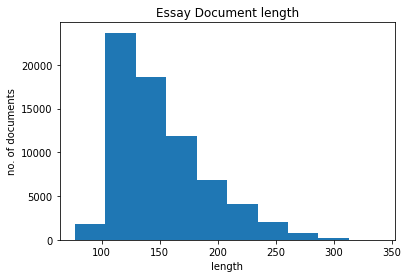

In [ ]:
plt.hist(doc_len_essay)
plt.title('Essay Document length')
plt.xlabel('length')
plt.ylabel('no. of documents')
plt.show()

In [ ]:
max_length= 300
padded_docs_train_essay = pad_sequences(encoded_docs_train_essay, maxlen=max_length, padding='post')
padded_docs_val_essay = pad_sequences(encoded_docs_val_essay, maxlen=max_length, padding='post')
padded_docs_test_essay = pad_sequences(encoded_docs_test_essay, maxlen=max_length, padding='post')

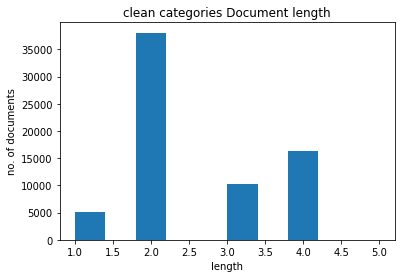

In [ ]:
plt.hist(doc_len_catg)
plt.title('clean categories Document length')
plt.xlabel('length')
plt.ylabel('no. of documents')
plt.show()

In [ ]:
padded_docs_train_clean_categories = pad_sequences(encoded_docs_train_clean_categories, maxlen=4, padding='post')
padded_docs_val_clean_categories = pad_sequences(encoded_docs_val_clean_categories, maxlen=4, padding='post')
padded_docs_test_clean_categories = pad_sequences(encoded_docs_test_clean_categories, maxlen=4, padding='post')

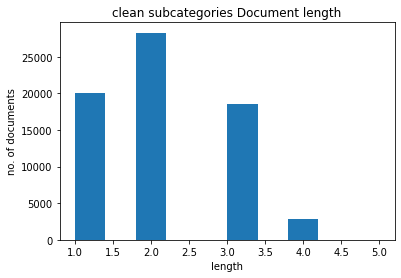

In [ ]:
plt.hist(doc_len_subcatg)
plt.title('clean subcategories Document length')
plt.xlabel('length')
plt.ylabel('no. of documents')
plt.show()

In [ ]:
padded_docs_train_clean_subcategories = pad_sequences(encoded_docs_train_clean_subcategories, maxlen=4, padding='post')
padded_docs_val_clean_subcategories = pad_sequences(encoded_docs_val_clean_subcategories, maxlen=4, padding='post')
padded_docs_test_clean_subcategories = pad_sequences(encoded_docs_test_clean_subcategories, maxlen=4, padding='post')

embedding matrix:

In [ ]:
with open('/content/drive/MyDrive/6_Donors_choose_NB/glove_vectors', 'rb') as f:
  modelg = pickle.load(f)
  glove_words =  set(modelg.keys())

In [ ]:
embedding_matrix=[np.zeros(300)]
for word in vocab_essay:
  if word in glove_words:
    embedding_matrix.append(modelg[word])
  else:
    embedding_matrix.append(np.zeros(300))
embedding_matrix = np.array(embedding_matrix)

In [ ]:
embedding_matrix.shape

(47333, 300)

standarizing numerical inputs

In [ ]:
scaler = StandardScaler()

price_train = scaler.fit_transform(X_train[['price']].values.reshape(-1, 1))
price_val = scaler.transform(X_val[['price']].values.reshape(-1, 1))
price_test = scaler.transform(X_test[['price']].values.reshape(-1, 1))

subm_train = scaler.fit_transform(X_train[['teacher_number_of_previously_posted_projects']].values.reshape(-1, 1))
subm_val = scaler.transform(X_val[['teacher_number_of_previously_posted_projects']].values.reshape(-1, 1))
subm_test = scaler.transform(X_test[['teacher_number_of_previously_posted_projects']].values.reshape(-1, 1))

numerical_features_train = tf.convert_to_tensor(np.hstack((price_train,subm_train)))
numerical_features_val = tf.convert_to_tensor(np.hstack((price_val,subm_val)))
numerical_features_test = tf.convert_to_tensor(np.hstack((price_test,subm_test)))

In [ ]:
numerical_features_train

<tf.Tensor: shape=(77073, 2), dtype=float64, numpy=
array([[-0.78534057, -0.22180927],
       [-0.59789358, -0.04287556],
       [-0.115708  ,  0.88757974],
       ...,
       [-0.70251516,  0.1718449 ],
       [-0.54067866, -0.25759601],
       [-0.38104902, -0.22180927]])>

Model:

In [ ]:
def model_1_2(model1=True,drop=0):

  if model1==True:
    input_layer_essay = Input(shape=(max_length,),name='essay')
    embed_essay = Embedding(vocab_size_essay, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer_essay)
  else:
    input_layer_essay = Input(shape=(max_length2,),name='essay')
    embed_essay = Embedding(vocab_size_essay2, 300, weights=[embedding_matrix2], input_length=max_length2, trainable=False)(input_layer_essay)

  lstm_essay = LSTM(units=128)(embed_essay)

  input_school_state = Input(shape=(1,),name='input_school_state')
  embed_school_state = Embedding(vocab_size_school_state, 27, input_length=1, trainable=True)(input_school_state)

  input_teacher_prefix = Input(shape=(1,),name='input_teacher_prefix')
  embed_teacher_prefix = Embedding(vocab_size_teacher_prefix, 4, input_length=1, trainable=True)(input_teacher_prefix)

  input_project_grade_category = Input(shape=(1,),name='input_project_grade_category') 
  embed_project_grade_category = Embedding(vocab_size_project_grade_category, 4, input_length=3, trainable=True)(input_project_grade_category)

  input_clean_categories = Input(shape=(4,),name='input_clean_categories') 
  embed_clean_categories = Embedding(vocab_size_clean_categories, 9, input_length=4, trainable=True)(input_clean_categories) 

  input_clean_subcategories	 = Input(shape=(4,),name='input_clean_subcategories') 
  embed_clean_subcategories	 = Embedding(vocab_size_clean_subcategories	, 20, input_length=4, trainable=True)(input_clean_subcategories) 

  input_numerical = Input(shape=(2,),name='numerical_features')
  dense_num = Dense(128,activation='relu',kernel_initializer=HeNormal)(input_numerical)

  flatten_essay = Flatten()(lstm_essay)
  flatten_school_state = Flatten()(embed_school_state)
  flatten_teacher_prefix = Flatten()(embed_teacher_prefix)
  flatten_project_grade_category = Flatten()(embed_project_grade_category)
  flatten_clean_categories = Flatten()(embed_clean_categories)
  flatten_clean_subcategories = Flatten()(embed_clean_subcategories)

  concat = Concatenate()([flatten_essay, flatten_school_state, flatten_teacher_prefix, flatten_project_grade_category, \
                          flatten_clean_categories, flatten_clean_subcategories, dense_num])
  dense1 = Dense(128,activation='relu',kernel_initializer=HeNormal)(concat)
  dense2 = Dense(64,activation='relu',kernel_initializer=HeNormal)(dense1)
  dropout = Dropout(drop)(dense2)
  dense3 = Dense(32,activation='relu',kernel_initializer=HeNormal)(dropout)
  output = Dense(1,activation='sigmoid')(dense3)

  model = Model(inputs=[input_layer_essay, input_school_state, input_teacher_prefix, input_project_grade_category, input_clean_categories, input_clean_subcategories, input_numerical],outputs=output)
  return model

In [ ]:
model1 = model_1_2()

In [ ]:
model1.summary()

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 essay (InputLayer)             [(None, 300)]        0           []                               
                                                                                                  
 embedding_38 (Embedding)       (None, 300, 300)     14199900    ['essay[0][0]']                  
                                                                                                  
 input_school_state (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 input_teacher_prefix (InputLay  [(None, 1)]         0           []                        

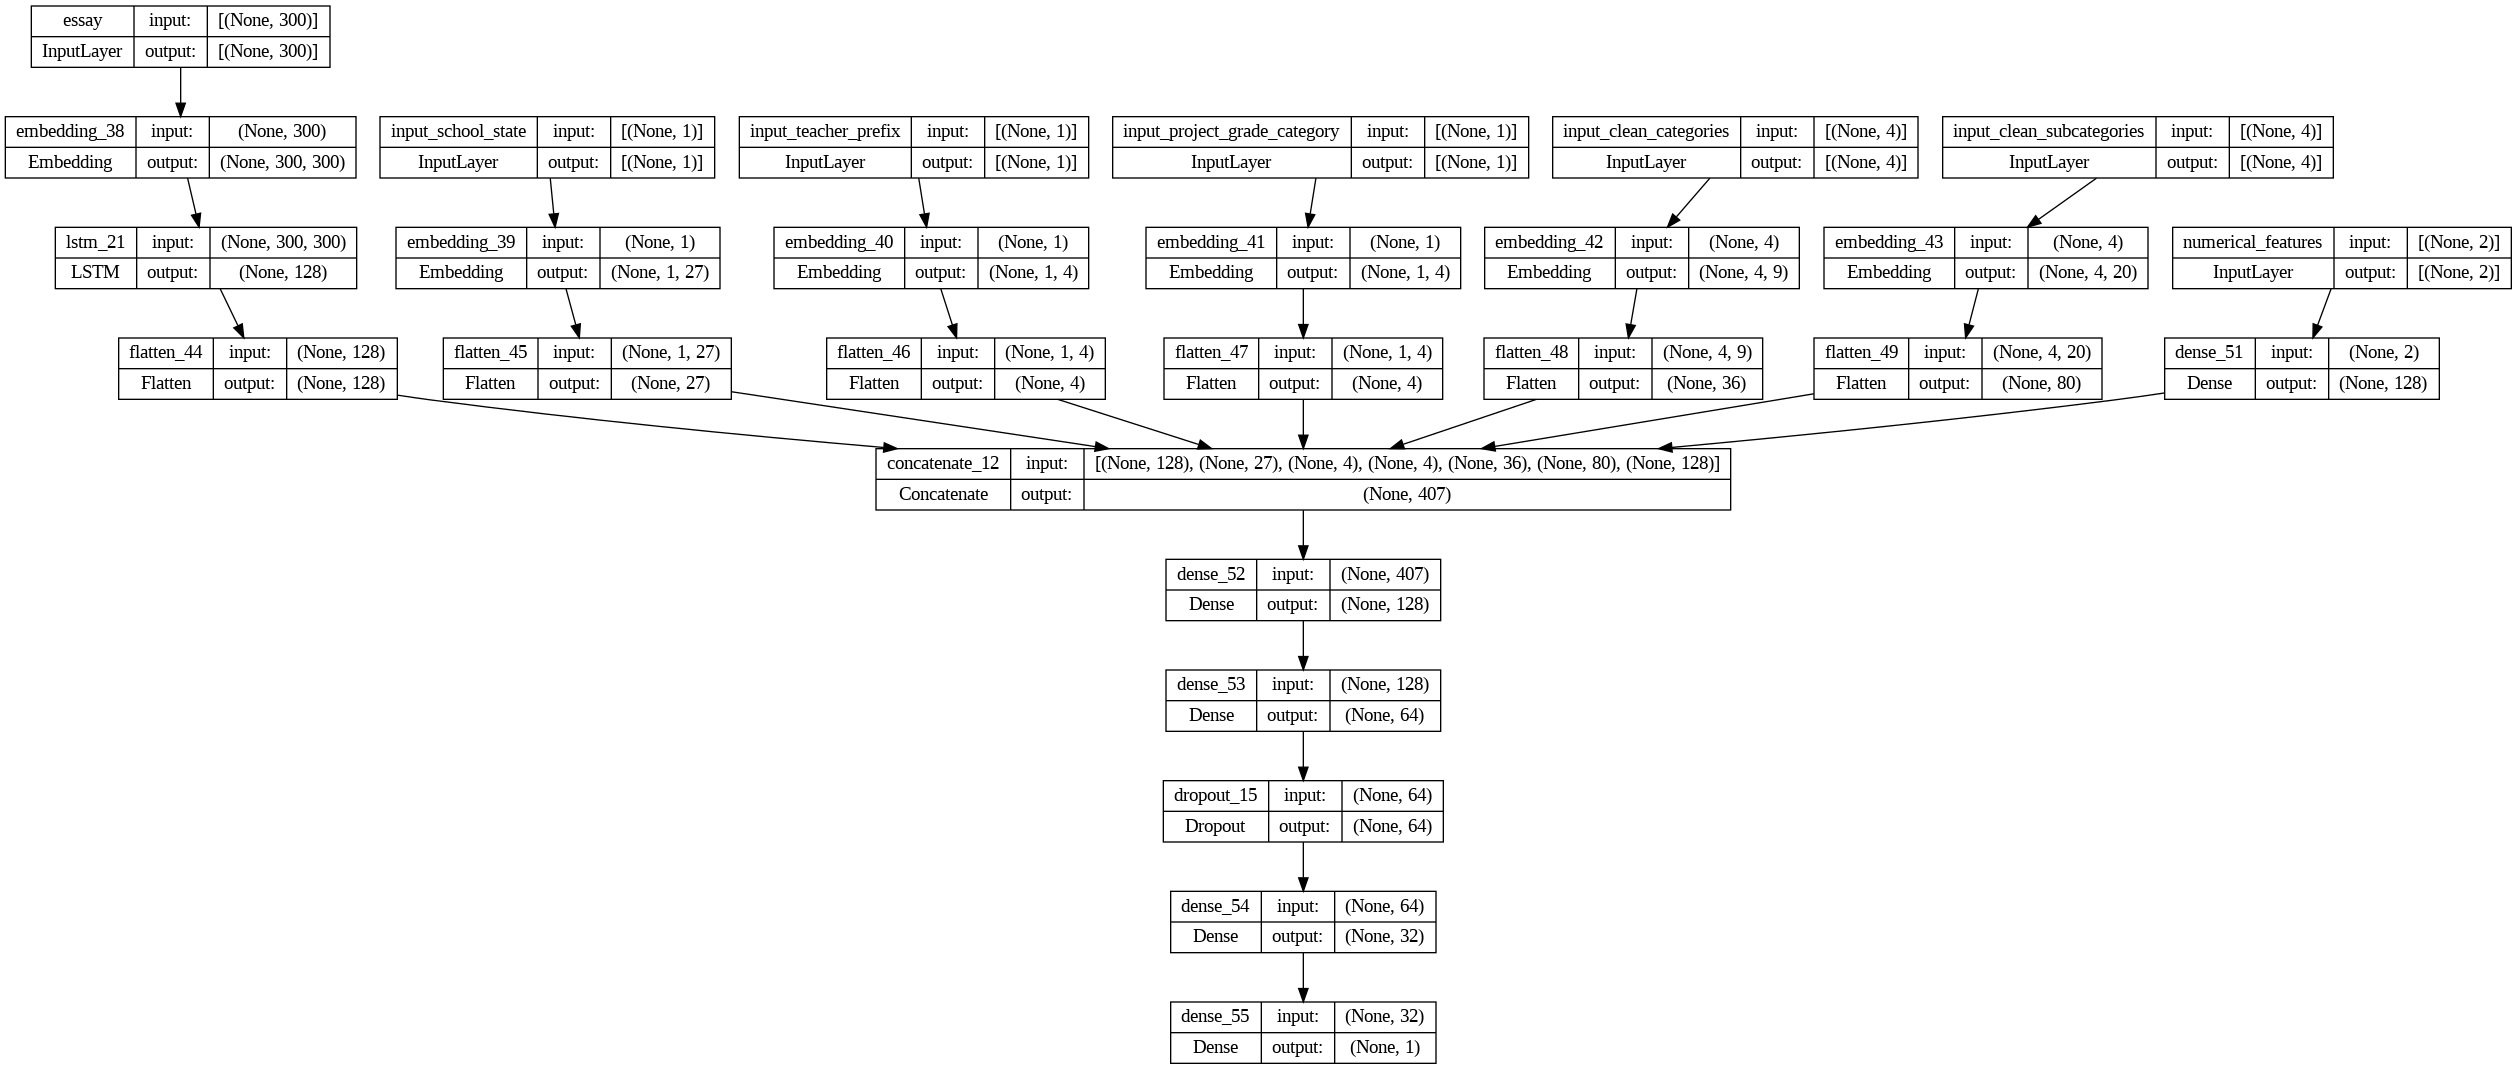

In [ ]:
tf.keras.utils.plot_model(model1,show_shapes=True)

Callbacks

In [ ]:
class RocCallback(tf.keras.callbacks.Callback): #https://stackoverflow.com/questions/41032551/how-to-compute-receiving-operating-characteristic-roc-and-auc-in-keras/46844409#46844409
    def __init__(self,training_data,validation_data):
        super(tf.keras.callbacks.Callback, self).__init__()
        self.x = training_data[0]
        self.y = training_data[1]
        self.x_val = validation_data[0]
        self.y_val = validation_data[1]
    def on_epoch_end(self, epoch, logs={}):
        y_pred_train = self.model.predict(self.x)
        roc_train = roc_auc_score(self.y, y_pred_train)
        y_pred_val = self.model.predict(self.x_val)
        roc_val = roc_auc_score(self.y_val, y_pred_val)
        print('\rroc-auc_train: %s - roc-auc_val: %s' % (str(round(roc_train,2)),str(round(roc_val,2))),end=100*' '+'\n')

In [ ]:
log_dir = os.path.join('/content/drive/MyDrive/lstmdonors/',"logs",'model1','fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

auc = RocCallback((train,y_train),(val,y_val))

modelsave_wt = tf.keras.callbacks.ModelCheckpoint(
                     filepath='/content/drive/MyDrive/lstmdonors/model.{epoch:02d}-{val_accuracy:.4f}.h5', 
                     save_freq='epoch', verbose=1, monitor='val_accuracy', 
                     save_weights_only=True, save_best_only=True
                 ) 

In [ ]:
%load_ext tensorboard

Training:

In [ ]:
train = [padded_docs_train_essay,encoded_docs_train_school_state,encoded_docs_train_teacher_prefix,encoded_docs_train_project_grade_category,padded_docs_train_clean_categories,padded_docs_train_clean_subcategories,numerical_features_train]
val = [padded_docs_val_essay,encoded_docs_val_school_state,encoded_docs_val_teacher_prefix,encoded_docs_val_project_grade_category,padded_docs_val_clean_categories,padded_docs_val_clean_subcategories,numerical_features_val]
test = [padded_docs_test_essay,encoded_docs_test_school_state,encoded_docs_test_teacher_prefix,encoded_docs_test_project_grade_category,padded_docs_test_clean_categories,padded_docs_test_clean_subcategories,numerical_features_test]

In [ ]:
model1.compile(loss = "binary_crossentropy", optimizer ='adam', metrics=['accuracy'])

In [ ]:
hist1 = model1.fit(train, y_train, validation_data=(val,y_val),epochs = 5,verbose=2,batch_size=64,callbacks=[auc,tensorboard_callback,modelsave_wt])

Epoch 1/5
616/616 [==============================] - 5s 7ms/step
roc-auc_train: 0.63 - roc-auc_val: 0.61                                                                                                    

Epoch 1: val_accuracy improved from -inf to 0.84860, saving model to /content/drive/MyDrive/lstmdonors/model.01-0.8486.h5
1092/1092 - 68s - loss: 0.4202 - auroc: 0.6116 - accuracy: 0.8483 - val_loss: 0.4161 - val_auroc: 0.6100 - val_accuracy: 0.8486 - 68s/epoch - 62ms/step
Epoch 2/5
616/616 [==============================] - 5s 7ms/step
roc-auc_train: 0.65 - roc-auc_val: 0.62                                                                                                    

Epoch 2: val_accuracy did not improve from 0.84860
1092/1092 - 50s - loss: 0.4116 - auroc: 0.6392 - accuracy: 0.8486 - val_loss: 0.4135 - val_auroc: 0.6227 - val_accuracy: 0.8486 - 50s/epoch - 46ms/step
Epoch 3/5
616/616 [==============================] - 4s 7ms/step
roc-auc_train: 0.7 - roc-auc_val: 0.68        

In [ ]:
y_pred1 = model1.predict(test,batch_size=64)

308/308 [==============================] - 3s 9ms/step


In [ ]:
roc_auc_score(y_test, y_pred1)

0.7278373339529133

###Model 2:

selecting idf range for reducing vocabulary size

In [ ]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(X_train.essay.values)
idf = vectorizer.idf_

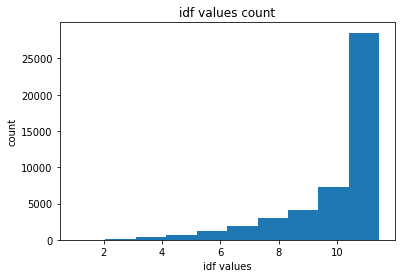

In [ ]:
plt.hist(idf)
plt.title('idf values count')
plt.xlabel('idf values')
plt.ylabel('count')
plt.show()

In [ ]:
np.quantile(idf,[0,0.01,0.05,0.1,0.15,0.2,.25,.5,.75,1])

array([ 1.00780677,  4.0560173 ,  6.18516846,  7.45705247,  8.25455967,
        8.90848614,  9.45853247, 11.06797039, 11.47343549, 11.47343549])

In [ ]:
np.quantile(idf,[0.9,0.95,.99])

array([11.47343549, 11.47343549, 11.47343549])

selecting range of [4,11]

In [ ]:
index=[]
min_idf = 4
max_idf = 11
for i in range(len(idf)):
  if idf[i]>=min_idf and idf[i]<=max_idf:
    index.append(i)

Vocabulary

In [ ]:
vocabulary = {j:i+1 for i,j in enumerate(vectorizer.get_feature_names_out()[index])}
len(vocabulary)

23149

In [ ]:
vocab_size_essay2 = len(vocabulary.keys())+1

Encoding

In [ ]:
def doc_encoding(doc,vocabulary):
  encoded_docs = []
  for i in doc:
    encoding=[]
    for word in i.split():
      try:
        encoding.append(vocabulary[word])
      except KeyError:
        continue
    encoded_docs.append(encoding)
  return encoded_docs

In [ ]:
encoded_docs_train_essay2 = doc_encoding(X_train.essay.values,vocabulary)
encoded_docs_val_essay2 = doc_encoding(X_val.essay.values,vocabulary)
encoded_docs_test_essay2 = doc_encoding(X_test.essay.values,vocabulary)

Padding

In [ ]:
doc_len2=[]
for i in encoded_docs_train_essay2:
  doc_len2.append(len(i))

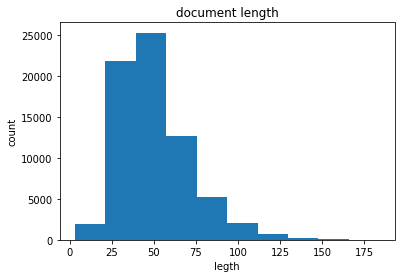

In [ ]:
plt.hist(doc_len2)
plt.title('document length')
plt.xlabel('legth')
plt.ylabel('count')
plt.show()

In [ ]:
np.quantile(doc_len2,np.arange(0.9,1.01,0.01))

array([ 79.,  81.,  83.,  85.,  88.,  91.,  95., 100., 106., 116., 183.])

In [ ]:
len(vocabulary)

23239

In [ ]:
max_length2 = 120
padded_docs_train_essay2 = pad_sequences(encoded_docs_train_essay2, maxlen=max_length2, padding='post')
padded_docs_val_essay2 = pad_sequences(encoded_docs_val_essay2, maxlen=max_length2, padding='post')
padded_docs_test_essay2 = pad_sequences(encoded_docs_test_essay2, maxlen=max_length2, padding='post')

embedding matrix

In [ ]:
embedding_matrix2=[np.zeros(300)]
for word in vocabulary.keys():
  if word in glove_words:
    embedding_matrix2.append(modelg[word])
  else:
    embedding_matrix2.append(np.zeros(300))
embedding_matrix2 = np.array(embedding_matrix2)

Model

In [ ]:
model2 = model_1_2(model1=False,drop=0.5)

In [ ]:
model2.summary()

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 essay (InputLayer)             [(None, 120)]        0           []                               
                                                                                                  
 embedding_44 (Embedding)       (None, 120, 300)     6945000     ['essay[0][0]']                  
                                                                                                  
 input_school_state (InputLayer  [(None, 1)]         0           []                               
 )                                                                                                
                                                                                                  
 input_teacher_prefix (InputLay  [(None, 1)]         0           []                        

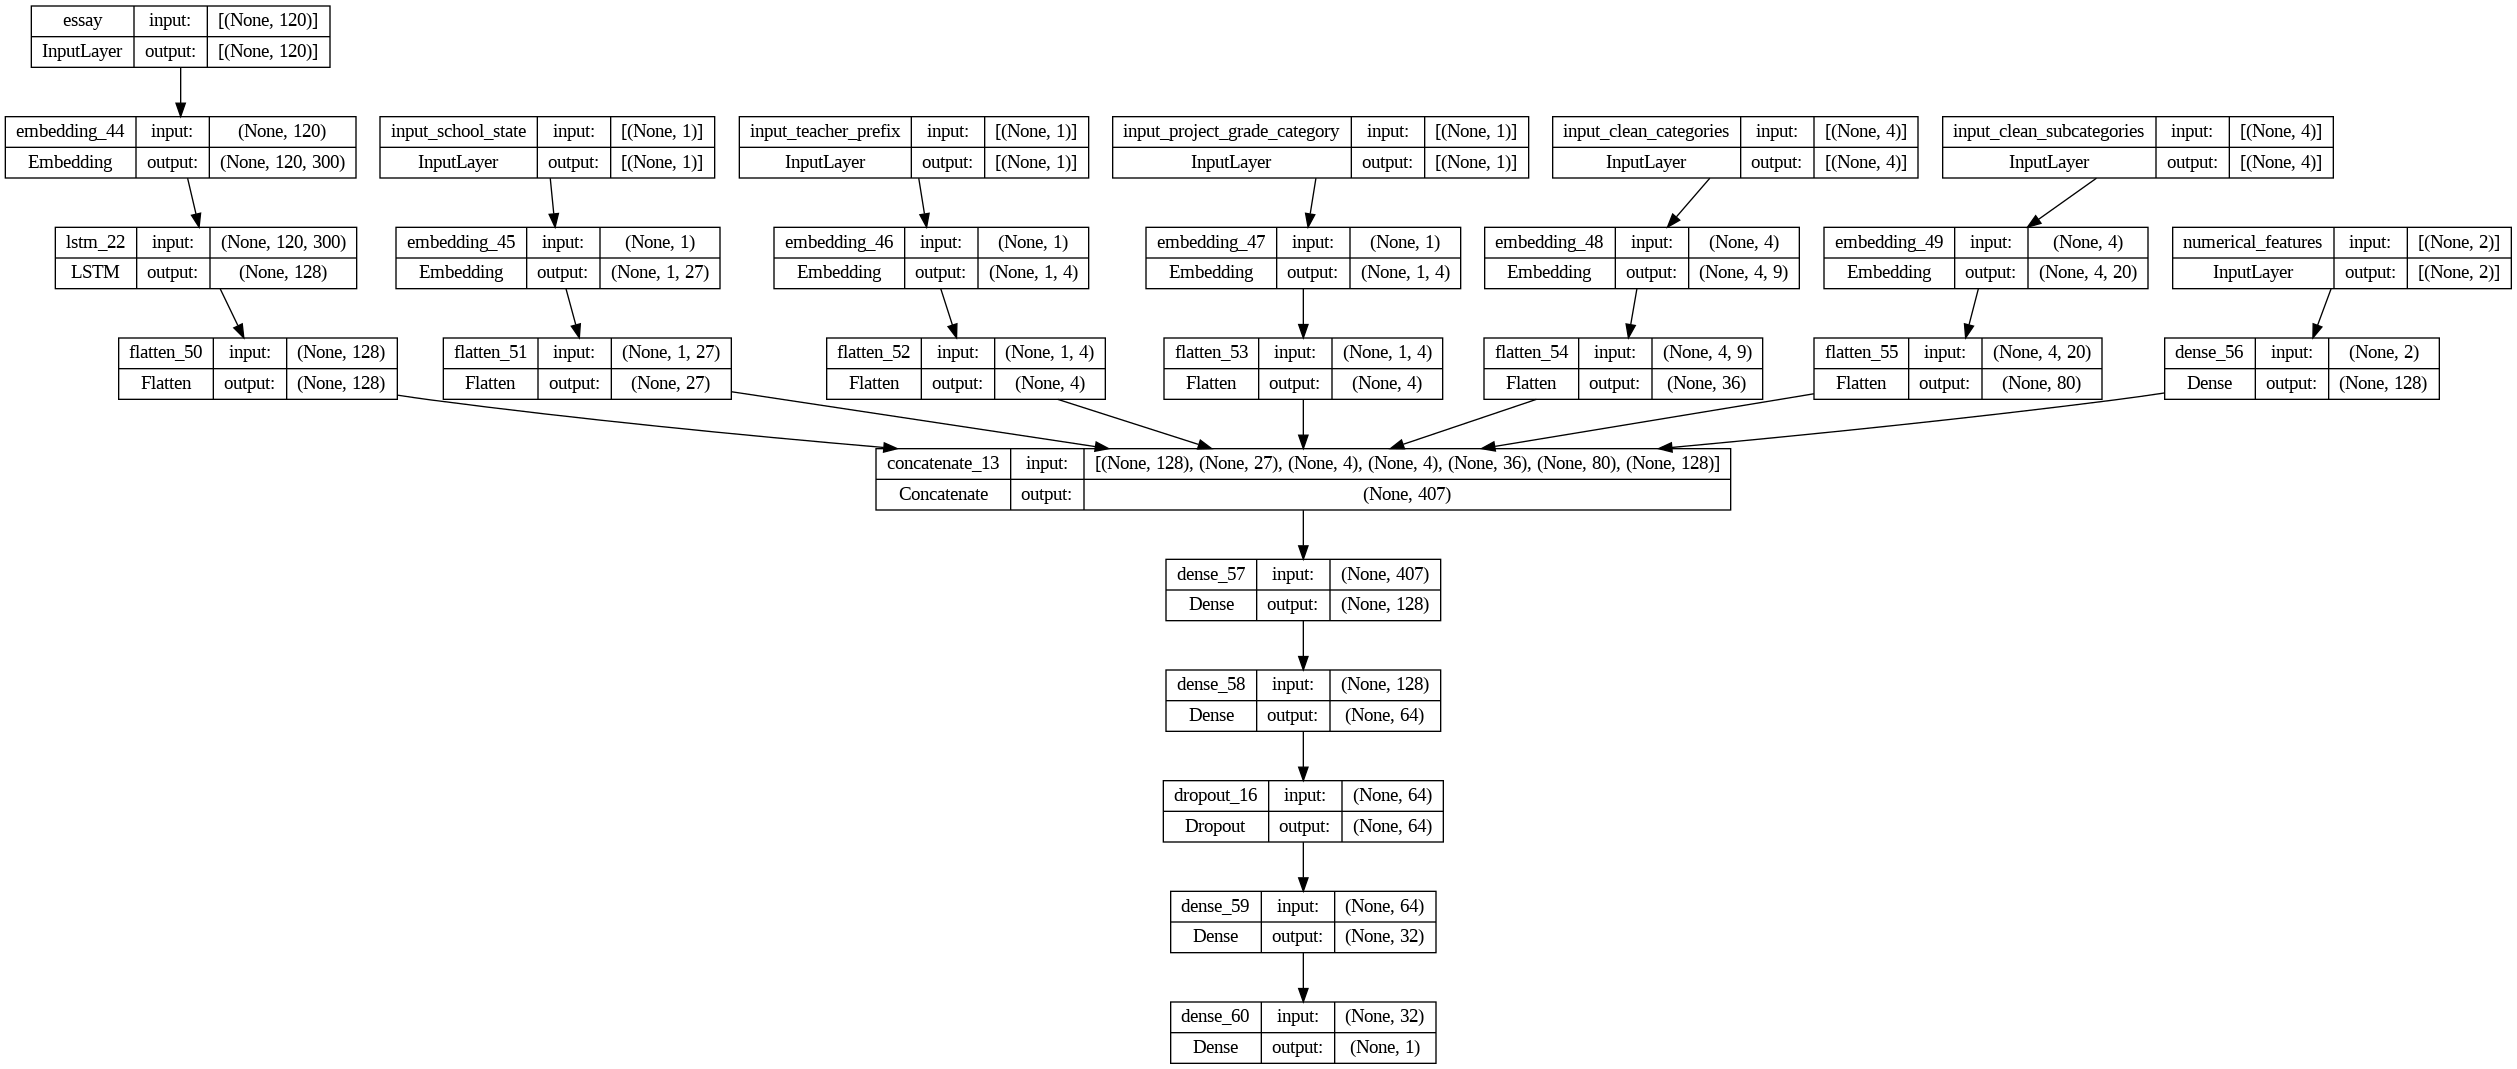

In [ ]:
tf.keras.utils.plot_model(model2,show_shapes=True)

callbacks

In [ ]:
log_dir = os.path.join('/content/drive/MyDrive/lstmdonors/',"logs",'model2','fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

auc = RocCallback((train2,y_train),(val2,y_val))

modelsave_wt = tf.keras.callbacks.ModelCheckpoint(
                     filepath='/content/drive/MyDrive/lstmdonors/model.{epoch:02d}-{val_accuracy:.4f}.h5', 
                     save_freq='epoch', verbose=1, monitor='val_accuracy', 
                     save_weights_only=True, save_best_only=True
                 ) 

training

In [ ]:
train2 = [padded_docs_train_essay2,encoded_docs_train_school_state,encoded_docs_train_teacher_prefix,encoded_docs_train_project_grade_category,padded_docs_train_clean_categories,padded_docs_train_clean_subcategories,numerical_features_train]
val2 = [padded_docs_val_essay2,encoded_docs_val_school_state,encoded_docs_val_teacher_prefix,encoded_docs_val_project_grade_category,padded_docs_val_clean_categories,padded_docs_val_clean_subcategories,numerical_features_val]
test2 = [padded_docs_test_essay2,encoded_docs_test_school_state,encoded_docs_test_teacher_prefix,encoded_docs_test_project_grade_category,padded_docs_test_clean_categories,padded_docs_test_clean_subcategories,numerical_features_test]

In [ ]:
model2.compile(loss = "binary_crossentropy", optimizer = 'adam' , metrics=['accuracy'])

In [ ]:
hist2 = model2.fit(train2, y_train ,validation_data=(val2,y_val),epochs = 4,verbose=2,batch_size=64,callbacks=[auc,tensorboard_callback,modelsave_wt])

Epoch 1/4
616/616 [==============================] - 3s 5ms/step
roc-auc_train: 0.62 - roc-auc_val: 0.61                                                                                                    

Epoch 1: val_accuracy did not improve from 0.85113
1092/1092 - 36s - loss: 0.4277 - accuracy: 0.8477 - val_loss: 0.4407 - val_accuracy: 0.8486 - 36s/epoch - 33ms/step
Epoch 2/4
616/616 [==============================] - 3s 5ms/step
roc-auc_train: 0.72 - roc-auc_val: 0.7                                                                                                    

Epoch 2: val_accuracy did not improve from 0.85113
1092/1092 - 32s - loss: 0.4025 - accuracy: 0.8484 - val_loss: 0.4104 - val_accuracy: 0.8486 - 32s/epoch - 29ms/step
Epoch 3/4
616/616 [==============================] - 3s 5ms/step
roc-auc_train: 0.74 - roc-auc_val: 0.71                                                                                                    

Epoch 3: val_accuracy did not improve from 0.8511

In [ ]:
y_pred2 = model2.predict(test2,batch_size=64)
roc_auc_score(y_test, y_pred2)

308/308 [==============================] - 2s 5ms/step


0.7248440381579335

###Model 3:

one hot encoding categorical features, standarizing numerical features for 1d convolution.

In [ ]:
transform = make_column_transformer(
    ( OneHotEncoder(handle_unknown='ignore') , (0, 1, 2, 4, 5) ), #onehot encoding of categorical features
    ( MinMaxScaler() , (3,7) )                                    #normalizing numerical features
    )

In [ ]:
input_conv_train = tf.convert_to_tensor(transform.fit_transform(X_train).toarray())
input_conv_val = tf.convert_to_tensor(transform.transform(X_val).toarray())
input_conv_test = tf.convert_to_tensor(transform.transform(X_test).toarray())
input_conv_train = tf.expand_dims(input_conv_train,2)
input_conv_val = tf.expand_dims(input_conv_val,2)
input_conv_test = tf.expand_dims(input_conv_test,2)

In [ ]:
input_conv_train.shape

TensorShape([69874, 496, 1])

model

In [ ]:
input_layer_others = Input(shape=(input_conv_train.shape[-2],1))
input_layer_essay = Input(shape=(max_length,),name='essay')

embed_essay = Embedding(vocab_size_essay, 300, weights=[embedding_matrix], input_length=max_length, trainable=False)(input_layer_essay)
lstm_essay = LSTM(units=400, return_sequences=True)(embed_essay)
lstm_essay2 = LSTM(units=400,return_sequences=True)(embed_essay)
avg = GlobalAveragePooling1D()(lstm_essay2)
flatten1 = Flatten()(avg)

conv1 = Conv1D(8,2,activation='relu')(input_layer_others)
conv2 = Conv1D(8,2,activation='relu')(conv1)
flatten2 = Flatten()(conv2)
concat = Concatenate()([flatten1,flatten2])
dense1 = Dense(256,activation='relu')(concat)
dropout1 = Dropout(0)(dense1)
dense2 = Dense(128,activation='relu')(dropout1)
dropout2 = Dropout(0)(dense2)
dense3 = Dense(64,activation='relu')(dropout2)
output = Dense(1,activation='sigmoid')(dense3)

model3 = Model(inputs=[input_layer_essay,input_layer_others], outputs=output)

In [ ]:
model3.summary()

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 essay (InputLayer)             [(None, 300)]        0           []                               
                                                                                                  
 embedding_50 (Embedding)       (None, 300, 300)     14199900    ['essay[0][0]']                  
                                                                                                  
 input_9 (InputLayer)           [(None, 496, 1)]     0           []                               
                                                                                                  
 lstm_24 (LSTM)                 (None, 300, 400)     1121600     ['embedding_50[0][0]']           
                                                                                           

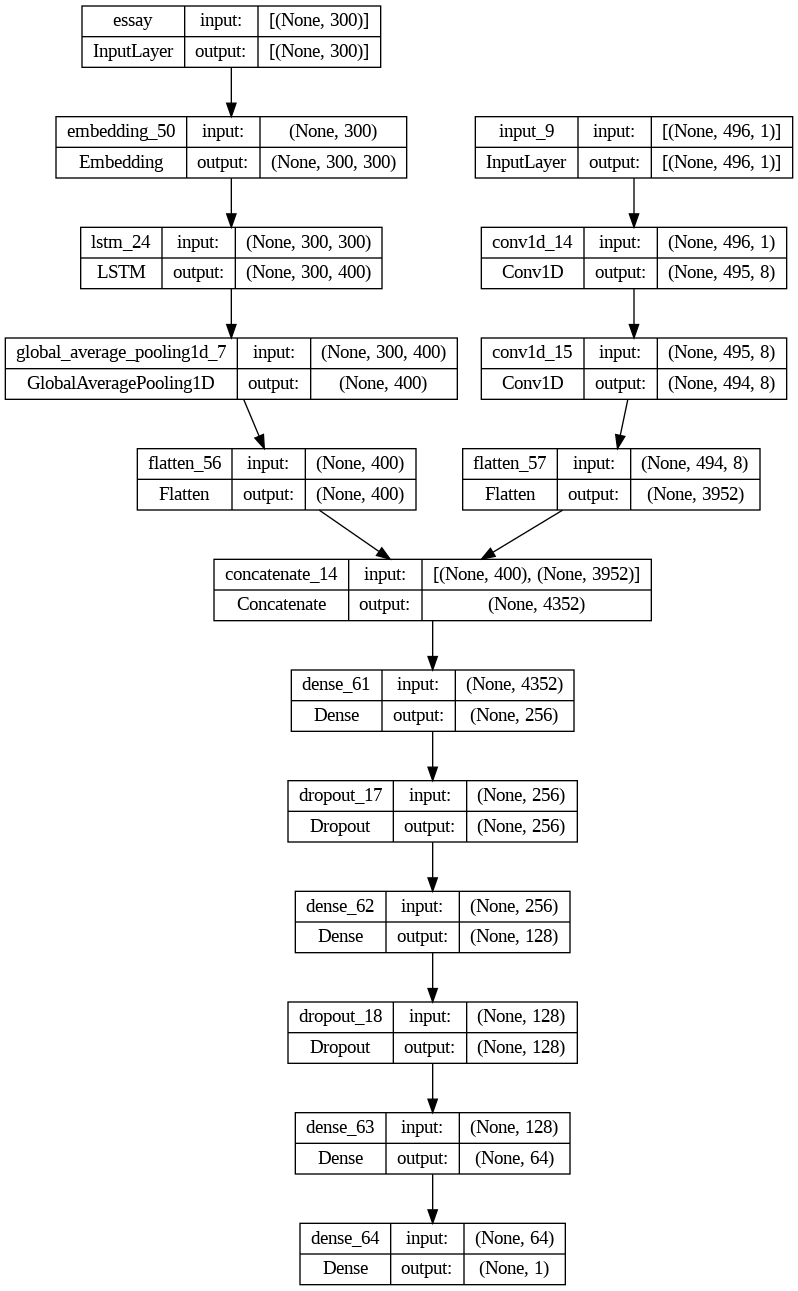

In [ ]:
tf.keras.utils.plot_model(model3,show_shapes=True)

callbacks

In [ ]:
log_dir = os.path.join('/content/drive/MyDrive/lstmdonors/',"logs",'model3','fits', datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard = tf.keras.callbacks.TensorBoard(log_dir=log_dir,histogram_freq=1,write_graph=True)

modelsave = tf.keras.callbacks.ModelCheckpoint(
                     filepath='model3.{epoch:02d}-{val_loss:.4f}.h5', 
                     save_freq='epoch', verbose=1, monitor='val_loss', 
                     save_weights_only=True, save_best_only=True
                 ) 

rocauc3 = RocCallback((train3,y_train),(val3,y_val))

training

In [ ]:
train3 = [padded_docs_train_essay,input_conv_train]
val3 = [padded_docs_val_essay,input_conv_val]
test3 = [padded_docs_test_essay,input_conv_test]

In [ ]:
model3.compile(loss = "binary_crossentropy", optimizer ='adam', metrics=['accuracy'])

In [ ]:
hist3 = model3.fit(train3, y_train, validation_data=(val3,y_val),epochs = 5,verbose=2,batch_size=64,callbacks=[rocauc3,tensorboard,modelsave])

Epoch 1/5
616/616 [==============================] - 9s 14ms/step
roc-auc_train: 0.70 - roc-auc_val: 0.68

Epoch 1: val_loss did not improve from 0.38683
1092/1092 - 108s - loss: 0.4142 - accuracy: 0.8486 - val_loss: 0.4047 - val_accuracy: 0.8486 - 108s/epoch - 99ms/step
Epoch 2/5
616/616 [==============================] - 9s 14ms/step
roc-auc_train: 0.75 - roc-auc_val: 0.73

Epoch 2: val_loss improved from 0.38683 to 0.38313, saving model to model3.02-0.3831.h5
1092/1092 - 117s - loss: 0.3893 - accuracy: 0.8493 - val_loss: 0.3831 - val_accuracy: 0.8512 - 117s/epoch - 107ms/step
Epoch 3/5
616/616 [==============================] - 9s 14ms/step
roc-auc_train: 0.78 - roc-auc_val: 0.74

Epoch 3: val_loss improved from 0.38313 to 0.37755, saving model to model3.03-0.3775.h5
1092/1092 - 117s - loss: 0.3767 - accuracy: 0.8512 - val_loss: 0.3775 - val_accuracy: 0.8520 - 117s/epoch - 108ms/step
Epoch 4/5
616/616 [==============================] - 9s 14ms/step
roc-auc_train: 0.81 - roc-auc_val:

In [ ]:
model3.load_weights('model3.04-0.3728.h5') #using weights of epoch 4
pred = model3.predict(test3)
roc_auc_score(y_test,pred)

615/615 [==============================] - 9s 14ms/step


0.7406911586668831

In [ ]:
columns = ["Model", "Train auc", "Validation auc", "Test auc"]
myTable = PrettyTable()
myTable.add_column(columns[0], ['Model-1','Model-2','Model-3'])
myTable.add_column(columns[1], [76,75,80])
myTable.add_column(columns[2], [73,71,75])
myTable.add_column(columns[3], [73,72,74])
print(myTable)

+---------+-----------+----------------+----------+
|  Model  | Train auc | Validation auc | Test auc |
+---------+-----------+----------------+----------+
| Model-1 |     76    |       73       |    73    |
| Model-2 |     75    |       71       |    72    |
| Model-3 |     80    |       75       |    74    |
+---------+-----------+----------------+----------+
